#  警察庁の交通事故に関するオープンデータを前処理して、事故からの死亡を予測するコード (機械学習)

In [74]:
import warnings
warnings.filterwarnings('ignore')
import tqdm
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

pd.set_option('max_columns',100)

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [34]:
traffic_accident_data = pd.read_pickle("data/traffic_accident_data.pickle")

In [56]:
traffic_accident_data.head()

,資料区分,都道府県コード,警察署等コード,本票番号,事故内容,死者数,負傷者数,路線コード,上下線,地点コード,市区町村コード,発生日時 年,発生日時 月,発生日時 日,発生日時 時,発生日時 分,昼夜,天候,地形,路面状態,道路形状,環状交差点の直径,信号機,一時停止規制 標識（当事者A）,一時停止規制 表示（当事者A）,一時停止規制 標識（当事者B）,一時停止規制 表示（当事者B）,車道幅員,道路線形,衝突地点,ゾーン規制,中央分離帯施設等,歩車道区分,事故類型,年齢（当事者A）,年齢（当事者B）,当事者種別（当事者A）,当事者種別（当事者B）,用途別（当事者A）,用途別（当事者B）,車両形状（当事者A）,車両形状（当事者B）,速度規制（指定のみ）（当事者A）,速度規制（指定のみ）（当事者B）,車両の衝突部位（当事者A）,車両の衝突部位（当事者B）,車両の損壊程度（当事者A）,車両の損壊程度（当事者B）,エアバッグの装備（当事者A）,エアバッグの装備（当事者B）,...,sityouson-name2,sityouson-name3,accident_type,road_cd_f4,road_cd_l1,road_type,road_bypass,road_updown_type,day_night_type,weather_type,terrain_type,road_condition_type,road_shape_type,roundabout_diameter_type,traffic_lights_type,pause_sign_type_a,pause_sign_type_b,pause_display_type_a,pause_display_type_b,road_width_type,road_alignment_type,zone_regulation_type,pedestrian_road_division_type,accident_vehicle_type,age_type_a,age_type_b,parties_type_a,parties_type_b,use_type_a,use_type_b,vehicle_shape_type_a,vehicle_shape_type_b,speed_regulation_type_a,speed_regulation_type_b,collision_site_type_a,collision_site_type_b,damage_to_vehicle_type_a,damage_to_vehicle_type_b,airbag_equipment_type_a,airbag_equipment_type_b,side_airbag_equipment_type_a,side_airbag_equipment_type_b,personal_injury_type_a,personal_injury_type_b,weekday_type,holiday_type,death_flag,latitude,longitude,third_mesh
0,1,10,59,1,2,0,1,40010,1,0,234,2020,1,6,7,20,11,2,3,3,14,0,7,0,23,0,23,4,9,20,70,1,4,21,45,65,3,4,31,31,1,1,4,4,42,13,3,3,2,1,...,NaN,北広島市,負傷,4001,0,高速自動車国道,現道区間又は包括路線,上,昼－明,曇,非市街地,舗装－凍結,単路－その他,環状交差点以外,施設なし,対象外当事者,対象外当事者,その他,その他,単路－9.0m以上,その他,中央分離帯,区分なし,車両相互,45～54歳,65～74歳,乗用車－普通車,乗用車－軽自動車,自家用,自家用,乗用車,乗用車,50㎞／ｈ以下,50㎞／ｈ以下,左_中央_右_中央,前_中央_後_中央,小破,小破,その他,装備あり作動,その他,その他,負傷,損傷なし,月,その他,0,42.9436,141.5189,64413431
1,1,10,59,2,2,0,1,40010,1,0,213,2020,1,16,6,39,23,1,3,1,14,0,7,0,23,0,23,4,9,1,70,1,4,21,65,45,3,13,31,1,1,11,10,10,80,16,2,2,2,2,...,NaN,苫小牧市,負傷,4001,0,高速自動車国道,現道区間又は包括路線,上,夜－明,晴,非市街地,舗装－乾燥,単路－その他,環状交差点以外,施設なし,対象外当事者,対象外当事者,その他,その他,単路－9.0m以上,単路（交差点付近を含む）,中央分離帯,区分なし,車両相互,65～74歳,45～54歳,乗用車－普通車,貨物車－普通車,自家用,事業用,乗用車,貨物車,指定の速度規制なし等,指定の速度規制なし等,前_左_それ以外,前_中央_後_右,中破,中破,その他,その他,その他,その他,損傷なし,負傷,木,その他,0,42.7131,141.6522,64410552
2,1,10,59,3,2,0,2,40130,1,0,224,2020,1,5,6,15,23,5,3,3,14,0,7,0,23,0,23,4,9,1,70,6,3,21,1,35,3,3,31,31,1,1,4,4,40,10,1,2,1,2,...,NaN,千歳市,負傷,4013,0,高速自動車国道,現道区間又は包括路線,上,夜－明,雪,非市街地,舗装－凍結,単路－その他,環状交差点以外,施設なし,対象外当事者,対象外当事者,その他,その他,単路－9.0m以上,単路（交差点付近を含む）,中央線－ポストコーン,区分あり－路側帯,車両相互,0～24歳,35～44歳,乗用車－普通車,乗用車－普通車,自家用,自家用,乗用車,乗用車,50㎞／ｈ以下,50㎞／ｈ以下,左_中央_それ以外,前_中央_それ以外,大破,中破,装備あり作動,その他,その他,その他,負傷,負傷,日,その他,0,42.8822,141.6600,64412552
3,1,10,59,4,2,0,1,40130,1,0,209,2020,1,24,15,20,12,5,3,3,11,0,7,0,23,0,23,4,9,1,70,6,3,21,55,55,3,3,31,31,1,1,4,4,47,84,2,2,1,2,...,NaN,夕張市,負傷,4013,0,高速自動車国道,現道区間又は包括路線,上,昼－昼,雪,非市街地,舗装－凍結,単路－トンネル,環状交差点以外,施設なし,対象外当事者,対象外当事者,その他,その他,単路－9.0m以上,単路（交差点付近を含む）,中央線－ポストコーン,区分あり－路側帯,車両相互,55～64歳,55～64歳,乗用車－普通車,乗用車－普通車,自家用,自家用,乗用車,乗用車,50㎞／ｈ以下,50㎞／ｈ以下,左_中央_後_左,前_左_左_中央,中破,中破,装備あり作動,その他,装備あり作動,その他,損傷なし,負傷,金,その他,0,42.9358,142.0911,64423027
4,1,10,101,1,2,0,1,39990,0,0,101,2019,12,22,18,51,22,2,1,1,1,0,7,1,22,9,22,15,9,30,70,4,2,21,35,25,3,3,31,31,1,1,3,3,10,40,3,3,2,2,...,NaN,中央区,負傷,3999,0,一般市町村道,現道区間又は包括路線,対象外,夜－夜,曇,市街地－人口集中,舗装－乾燥,交差点－その他,環状交差点以外,施設なし,標準－反射式,規制なし,表示なし,表示なし,交差点－中（5.5m以上）－中,交差点内,中央線－ペイント,区分あり－縁石・ブロック等,車両相互,35～44歳,25～34歳,乗用車－普通車,乗用車－普通車,自家用,自家用,乗用車,乗用車,40㎞／ｈ以下,40㎞／ｈ以下,前_中央_それ以外,左_中央_それ以外,小破,小破,その他,その他,その他,その他,損傷なし,負傷,日,その他,0,43.0492,141.3547,64414258


# メッシュ

メッシュについて<br>
http://www.nilim.go.jp/lab/bcg/siryou/tnn/tnn0574pdf/ks057408.pdf <br>

メッシュ計算用のコード<br>
https://www.gis-py.com/entry/py-latlon2mesh

In [35]:
def dms2deg(dms):    
    # 度分秒から度への変換
    if len(str(dms)) == 10:        
        h = int(str(dms)[0:3])
        m = int(str(dms)[3:5])
        s = int(str(dms)[5:7])
    elif len(str(dms)) == 9:
        h = int(str(dms)[0:2])
        m = int(str(dms)[2:4])
        s = int(str(dms)[4:6])
    deg = Decimal(str(h + (m / 60) + (s / 3600))).quantize(Decimal('0.0001'), rounding=ROUND_HALF_UP)
    return str(deg)

In [36]:
traffic_accident_data = traffic_accident_data[traffic_accident_data["地点\u3000緯度（北緯）"] > 100000]
traffic_accident_data = traffic_accident_data[traffic_accident_data["地点\u3000経度（東経）"] > 100000].reset_index(drop=True)

In [37]:
traffic_accident_data["latitude"] = list(map(lambda id:dms2deg(traffic_accident_data["地点\u3000緯度（北緯）"][id]),
                                                                                     range(traffic_accident_data.index.size)))
traffic_accident_data["longitude"] = list(map(lambda id:dms2deg(traffic_accident_data["地点\u3000経度（東経）"][id]),
                                                                                     range(traffic_accident_data.index.size)))

traffic_accident_data["latitude"] = traffic_accident_data["latitude"].astype(float)
traffic_accident_data["longitude"] = traffic_accident_data["longitude"].astype(float)

In [38]:
def latlon2mesh(lat, lon):
    #1次メッシュ上2けた
    quotient_lat, remainder_lat = divmod(lat * 60, 40)
    first2digits = str(quotient_lat)[0:2]

    #1次メッシュ下2けた
    last2digits = str(lon - 100)[0:2]
    remainder_lon = lon - int(last2digits) - 100

    #1次メッシュ
    first_mesh = first2digits + last2digits

    #2次メッシュ上1けた
    first1digits, remainder_lat = divmod(remainder_lat, 5)

    #2次メッシュ下1けた
    last1digits, remainder_lon = divmod(remainder_lon * 60, 7.5)

    #2次メッシュ
    second_mesh = first_mesh + str(first1digits)[0:1] + str(last1digits)[0:1]

    #3次メッシュ上1けた
    first1digits, remainder_lat = divmod(remainder_lat * 60, 30)

    #3次メッシュ下1けた
    last1digits, remainder_lon = divmod(remainder_lon * 60, 45)

    #3次メッシュ
    third_mesh = second_mesh + str(first1digits)[0:1] + str(last1digits)[0:1]
    
    return third_mesh

In [39]:
%%time
traffic_accident_data["third_mesh"] = list(map(lambda id:latlon2mesh(traffic_accident_data.latitude[id],
                                                                traffic_accident_data.longitude[id]), range(traffic_accident_data.index.size)))



CPU times: user 6.42 s, sys: 18.6 ms, total: 6.44 s
Wall time: 6.44 s


# 機械学習

* 事故が起きた際に死亡事故が発生するかどうかを予測する
    * 理想はそのエリアで死亡事故が発生するかどうかを予測すること
    * 緯度経度からメッシュ単位のデータに変換
        * 予測対象は35518地点
        * しかし、予測時に使えるデータがないのでは？
        * 天候、時間帯、曜日、季節マター
        * 地域マター
            * メッシュ情報で表現
* 2019年のデータで学習して、2020年を予測
* personal_injury_type_a, personal_injury_type_b, death_flag, accident_typeは除外

In [40]:
# テスト用
test_df = traffic_accident_data[traffic_accident_data.accident_date > "2020-12-01"].reset_index(drop=True)
test_df.shape

(24129, 115)

In [41]:
traffic_accident_data.accident_date.describe()

count                  690300
unique                 340005
top       2019-11-22 17:20:00
freq                       22
first     2015-12-12 17:00:00
last      2020-12-31 22:57:00
Name: accident_date, dtype: object

In [42]:
# 学習用
train_df = traffic_accident_data[(traffic_accident_data.accident_date >= "2019-09-01") &\
                                                   (traffic_accident_data.accident_date <= "2020-12-01")].reset_index(drop=True)
train_df.shape

(405805, 115)

# メッシュごとの特徴量作成

In [43]:
# メッシュごとの特徴量作成用
mesh_df = traffic_accident_data[(traffic_accident_data.accident_date > "2019-01-01") &\
                                                   (traffic_accident_data.accident_date < "2019-09-01")].reset_index(drop=True)
mesh_df.shape

(249921, 115)

In [44]:
mesh_summary_df = mesh_df.groupby('third_mesh')['death_flag'].agg([np.sum, "count"]).reset_index()
mesh_summary_df.columns = ["third_mesh", "death_count", "accident_count"]
mesh_summary_df.tail()

,third_mesh,death_count,accident_count
44738,68410593,0,1
44739,68410594,0,1
44740,68410680,0,1
44741,68411042,0,1
44742,68411504,0,1


In [45]:
summary_column_name_list = ["road_type","road_bypass","road_updown_type","day_night_type","weather_type",
                                                "terrain_type","road_condition_type","road_shape_type","traffic_lights_type",
                                                "pause_sign_type_a","pause_sign_type_b","pause_display_type_a","pause_display_type_b",
                                                "road_width_type","road_alignment_type","zone_regulation_type",
                                                "pedestrian_road_division_type","accident_vehicle_type","age_type_a","age_type_b",
                                                "parties_type_a","parties_type_b","use_type_a","use_type_b","vehicle_shape_type_a",
                                                "vehicle_shape_type_b","speed_regulation_type_a","speed_regulation_type_b",
                                                "collision_site_type_a","collision_site_type_b","damage_to_vehicle_type_a",
                                                "damage_to_vehicle_type_b","airbag_equipment_type_a","airbag_equipment_type_b",
                                                "side_airbag_equipment_type_a","side_airbag_equipment_type_b","weekday_type","holiday_type"]

for each_variable_name in summary_column_name_list:
    df_pv = pd.pivot_table(data=mesh_df,
                                       fill_value=0,
                                       index="third_mesh",
                                       columns=each_variable_name,
                                       aggfunc = {each_variable_name:"count"}).reset_index()
    
    column_list = [df_pv.columns.levels[0][1]]
    add_column_list = [ each_variable_name + "_" + str(_) for _ in df_pv.columns.levels[1].tolist()[:-1]]
    column_list.extend(add_column_list)
    df_pv.columns = column_list
    mesh_summary_df = pd.merge(mesh_summary_df, df_pv, on="third_mesh", how="left")
    print(each_variable_name)

road_type
road_bypass
road_updown_type
day_night_type
weather_type
terrain_type
road_condition_type
road_shape_type
traffic_lights_type
pause_sign_type_a
pause_sign_type_b
pause_display_type_a
pause_display_type_b
road_width_type
road_alignment_type
zone_regulation_type
pedestrian_road_division_type
accident_vehicle_type
age_type_a
age_type_b
parties_type_a
parties_type_b
use_type_a
use_type_b
vehicle_shape_type_a
vehicle_shape_type_b
speed_regulation_type_a
speed_regulation_type_b
collision_site_type_a
collision_site_type_b
damage_to_vehicle_type_a
damage_to_vehicle_type_b
airbag_equipment_type_a
airbag_equipment_type_b
side_airbag_equipment_type_a
side_airbag_equipment_type_b
weekday_type
holiday_type


In [47]:
mesh_summary_df.tail()

,third_mesh,death_count,accident_count,road_type_その他,road_type_一般の交通の用に供するその他の道路,road_type_一般国道（国道番号）,road_type_一般市町村道,road_type_一般都道府県道,road_type_主要地方道－市道,road_type_主要地方道－都道府県道,road_type_林道,road_type_港湾道,road_type_私道,road_type_自動車専用道－その他,road_type_自動車専用道－指定,road_type_農（免）道,road_type_道路運送法上の道路,road_type_高速自動車国道,road_bypass_バイパス区間,road_bypass_現道区間又は包括路線,road_updown_type_上,road_updown_type_下,road_updown_type_対象外,day_night_type_ 昼－昼,day_night_type_ 昼－暮,day_night_type_夜－夜,day_night_type_夜－明,day_night_type_夜－暮,day_night_type_昼－明,weather_type_晴,weather_type_曇,weather_type_雨,weather_type_雪,weather_type_霧,terrain_type_市街地－その他,terrain_type_市街地－人口集中,terrain_type_非市街地,road_condition_type_舗装－乾燥,road_condition_type_舗装－凍結,road_condition_type_舗装－湿潤,road_condition_type_舗装－積雪,road_condition_type_非舗装,road_shape_type_一般交通の場所,road_shape_type_交差点付近－その他,road_shape_type_交差点付近－環状交差点付近,road_shape_type_交差点－その他,road_shape_type_交差点－環状交差点,road_shape_type_単路－その他,road_shape_type_単路－カーブ・屈折,road_shape_type_単路－トンネル,...,collision_site_type_b_後_右_それ以外,collision_site_type_b_後_右_前_中央,collision_site_type_b_後_右_前_右,collision_site_type_b_後_右_前_左,collision_site_type_b_後_右_右_中央,collision_site_type_b_後_右_左_中央,collision_site_type_b_後_右_後_中央,collision_site_type_b_後_右_後_右,collision_site_type_b_後_右_後_左,collision_site_type_b_後_左_それ以外,collision_site_type_b_後_左_前_中央,collision_site_type_b_後_左_前_右,collision_site_type_b_後_左_前_左,collision_site_type_b_後_左_右_中央,collision_site_type_b_後_左_左_中央,collision_site_type_b_後_左_後_中央,collision_site_type_b_後_左_後_右,collision_site_type_b_後_左_後_左,damage_to_vehicle_type_a_中破,damage_to_vehicle_type_a_大破,damage_to_vehicle_type_a_対象外当事者,damage_to_vehicle_type_a_小破,damage_to_vehicle_type_a_損壊なし,damage_to_vehicle_type_b_中破,damage_to_vehicle_type_b_大破,damage_to_vehicle_type_b_対象外当事者,damage_to_vehicle_type_b_小破,damage_to_vehicle_type_b_損壊なし,airbag_equipment_type_a_その他,airbag_equipment_type_a_対象外当事者,airbag_equipment_type_a_装備あり作動,airbag_equipment_type_b_その他,airbag_equipment_type_b_対象外当事者,airbag_equipment_type_b_装備あり作動,side_airbag_equipment_type_a_その他,side_airbag_equipment_type_a_対象外当事者,side_airbag_equipment_type_a_装備あり作動,side_airbag_equipment_type_b_その他,side_airbag_equipment_type_b_対象外当事者,side_airbag_equipment_type_b_装備あり作動,weekday_type_土,weekday_type_日,weekday_type_月,weekday_type_木,weekday_type_水,weekday_type_火,weekday_type_金,holiday_type_その他,holiday_type_前日,holiday_type_当日
44738,68410593,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
44739,68410594,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
44740,68410680,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
44741,68411042,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
44742,68411504,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


## 使わないデータを落とす

In [48]:
teacher_flag = train_df.death_flag

train_columns = ["weekday_type", "holiday_type", "pref_name", "road_type",
                          "road_bypass", "road_updown_type", "day_night_type",
                          "weather_type", "terrain_type", "road_condition_type",
                          "road_shape_type", "traffic_lights_type", "pause_sign_type_a",
                          "pause_display_type_a", "road_width_type", "road_alignment_type",
                          "zone_regulation_type", "pedestrian_road_division_type",
                          "speed_regulation_type_a", "third_mesh"]

train_df = train_df[train_columns]

In [49]:
# 一気にカテゴリ化
cols = train_columns[:-1]
train_df[cols] = train_df[cols].astype('category')

In [51]:
# ダミー変数を一気に作る
for each_columns in cols:
    dummy_df = pd.get_dummies( train_df[each_columns], drop_first= False)
    dummy_df.columns =  ["dummy_" + each_columns + "_" + str(i) for i in dummy_df.columns.tolist()]
    
    train_df = pd.concat([train_df, dummy_df], axis=1)

In [55]:
train_df.head()

,weekday_type,holiday_type,pref_name,road_type,road_bypass,road_updown_type,day_night_type,weather_type,terrain_type,road_condition_type,road_shape_type,traffic_lights_type,pause_sign_type_a,pause_display_type_a,road_width_type,road_alignment_type,zone_regulation_type,pedestrian_road_division_type,speed_regulation_type_a,third_mesh,dummy_weekday_type_土,dummy_weekday_type_日,dummy_weekday_type_月,dummy_weekday_type_木,dummy_weekday_type_水,dummy_weekday_type_火,dummy_weekday_type_金,dummy_holiday_type_その他,dummy_holiday_type_前日,dummy_holiday_type_当日,dummy_pref_name_三重,dummy_pref_name_京都,dummy_pref_name_佐賀,dummy_pref_name_兵庫,dummy_pref_name_北海道（函館方面）,dummy_pref_name_北海道（北見方面）,dummy_pref_name_北海道（旭川方面）,dummy_pref_name_北海道（札幌方面）,dummy_pref_name_北海道（釧路方面）,dummy_pref_name_千葉,dummy_pref_name_和歌山,dummy_pref_name_埼玉,dummy_pref_name_大分,dummy_pref_name_大阪,dummy_pref_name_奈良,dummy_pref_name_宮城,dummy_pref_name_宮崎,dummy_pref_name_富山,dummy_pref_name_山口,dummy_pref_name_山形,...,dummy_pause_sign_type_a_その他,dummy_pause_sign_type_a_対象外当事者,dummy_pause_sign_type_a_拡大－内部照明式,dummy_pause_sign_type_a_拡大－反射式,dummy_pause_sign_type_a_拡大－自発光式,dummy_pause_sign_type_a_標準－内部照明式,dummy_pause_sign_type_a_標準－反射式,dummy_pause_sign_type_a_標準－自発光式,dummy_pause_sign_type_a_縮小,dummy_pause_sign_type_a_規制なし,dummy_pause_display_type_a_その他,dummy_pause_display_type_a_表示あり,dummy_pause_display_type_a_表示なし,dummy_road_width_type_一般交通の場所,dummy_road_width_type_交差点－中（5.5m以上）－中,dummy_road_width_type_交差点－中（5.5m以上）－小,dummy_road_width_type_交差点－大（13.0ｍ以上）－中,dummy_road_width_type_交差点－大（13.0ｍ以上）－大,dummy_road_width_type_交差点－大（13.0ｍ以上）－小,dummy_road_width_type_交差点－小（5.5m未満）－小,dummy_road_width_type_単路－13.0m以上,dummy_road_width_type_単路－19.5m以上,dummy_road_width_type_単路－3.5m以上,dummy_road_width_type_単路－3.5m未満,dummy_road_width_type_単路－5.5m以上,dummy_road_width_type_単路－9.0m以上,dummy_road_alignment_type_その他,dummy_road_alignment_type_交差点内,dummy_road_alignment_type_単路（交差点付近を含む）,dummy_zone_regulation_type_一般交通の場所,dummy_zone_regulation_type_中央分離なし,dummy_zone_regulation_type_中央分離帯,dummy_zone_regulation_type_中央線－チャッターバー等,dummy_zone_regulation_type_中央線－ペイント,dummy_zone_regulation_type_中央線－ポストコーン,dummy_zone_regulation_type_中央線－高輝度標示,dummy_pedestrian_road_division_type_区分あり－縁石・ブロック等,dummy_pedestrian_road_division_type_区分あり－路側帯,dummy_pedestrian_road_division_type_区分あり－防護柵等,dummy_pedestrian_road_division_type_区分なし,dummy_speed_regulation_type_a_100㎞/h以下,dummy_speed_regulation_type_a_20㎞／ｈ以下,dummy_speed_regulation_type_a_30㎞／ｈ以下,dummy_speed_regulation_type_a_40㎞／ｈ以下,dummy_speed_regulation_type_a_50㎞／ｈ以下,dummy_speed_regulation_type_a_60㎞／ｈ以下,dummy_speed_regulation_type_a_70㎞／ｈ以下,dummy_speed_regulation_type_a_80㎞／ｈ以下,dummy_speed_regulation_type_a_対象外当事者,dummy_speed_regulation_type_a_指定の速度規制なし等
0,月,その他,北海道（札幌方面）,高速自動車国道,現道区間又は包括路線,上,昼－明,曇,非市街地,舗装－凍結,単路－その他,施設なし,対象外当事者,その他,単路－9.0m以上,その他,中央分離帯,区分なし,50㎞／ｈ以下,64413431,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,木,その他,北海道（札幌方面）,高速自動車国道,現道区間又は包括路線,上,夜－明,晴,非市街地,舗装－乾燥,単路－その他,施設なし,対象外当事者,その他,単路－9.0m以上,単路（交差点付近を含む）,中央分離帯,区分なし,指定の速度規制なし等,64410552,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,日,その他,北海道（札幌方面）,高速自動車国道,現道区間又は包括路線,上,夜－明,雪,非市街地,舗装－凍結,単路－その他,施設なし,対象外当事者,その他,単路－9.0m以上,単路（交差点付近を含む）,中央線－ポストコーン,区分あり－路側帯,50㎞／ｈ以下,64412552,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,金,その他,北海道（札幌方面）,高速自動車国道,現道区間又は包括路線,上,昼－昼,雪,非市街地,舗装－凍結,単路－トンネル,施設なし,対象外当事者,その他,単路－9.0m以上,単路（交差点付近を含む）,中央線－ポストコーン,区分あり－路側帯,50㎞／ｈ以下,64423027,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,日,その他,北海道（札幌方面）,一般市町村道,現道区間又は包括路線,対象外,夜－夜,曇,市街地－人口集中,舗装－乾燥,交差点－その他

## ダミー変数のみ残す

In [53]:
train_df.filter(regex="dummy_weekday_type").head()

,dummy_weekday_type_土,dummy_weekday_type_日,dummy_weekday_type_月,dummy_weekday_type_木,dummy_weekday_type_水,dummy_weekday_type_火,dummy_weekday_type_金
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0


In [57]:
dataset = pd.concat([train_df["third_mesh"],
                                train_df.filter(regex="dummy_weekday_type"),
                                train_df.filter(regex="dummy_holiday_type"),
                                train_df.filter(regex="dummy_pref_name"),
                                train_df.filter(regex="dummy_road_type"),
                                train_df.filter(regex="dummy_road_bypass"),
                                train_df.filter(regex="dummy_road_updown_type"),
                                train_df.filter(regex="dummy_day_night_type"),
                                train_df.filter(regex="dummy_weather_type"),
                                train_df.filter(regex="dummy_terrain_type"),
                                train_df.filter(regex="dummy_road_condition_type"),
                                train_df.filter(regex="dummy_road_shape_type"),
                                train_df.filter(regex="dummy_traffic_lights_type"),
                                train_df.filter(regex="dummy_pause_sign_type_a"),
                                train_df.filter(regex="dummy_pause_display_type_a"),
                                train_df.filter(regex="dummy_road_width_type"),
                                train_df.filter(regex="dummy_road_alignment_type"),
                                train_df.filter(regex="dummy_zone_regulation_type"),
                                train_df.filter(regex="dummy_pedestrian_road_division_type"),
                                train_df.filter(regex="dummy_speed_regulation_type_a"),
                      ], axis=1)

dataset = pd.merge(dataset, mesh_summary_df, on="third_mesh", how="left")

In [58]:
dataset = dataset.fillna(-1)

In [81]:
dataset.tail() #説明変数

,third_mesh,dummy_weekday_type_土,dummy_weekday_type_日,dummy_weekday_type_月,dummy_weekday_type_木,dummy_weekday_type_水,dummy_weekday_type_火,dummy_weekday_type_金,dummy_holiday_type_その他,dummy_holiday_type_前日,dummy_holiday_type_当日,dummy_pref_name_三重,dummy_pref_name_京都,dummy_pref_name_佐賀,dummy_pref_name_兵庫,dummy_pref_name_北海道（函館方面）,dummy_pref_name_北海道（北見方面）,dummy_pref_name_北海道（旭川方面）,dummy_pref_name_北海道（札幌方面）,dummy_pref_name_北海道（釧路方面）,dummy_pref_name_千葉,dummy_pref_name_和歌山,dummy_pref_name_埼玉,dummy_pref_name_大分,dummy_pref_name_大阪,dummy_pref_name_奈良,dummy_pref_name_宮城,dummy_pref_name_宮崎,dummy_pref_name_富山,dummy_pref_name_山口,dummy_pref_name_山形,dummy_pref_name_山梨,dummy_pref_name_岐阜,dummy_pref_name_岡山,dummy_pref_name_岩手,dummy_pref_name_島根,dummy_pref_name_広島,dummy_pref_name_徳島,dummy_pref_name_愛媛,dummy_pref_name_愛知,dummy_pref_name_新潟,dummy_pref_name_東京,dummy_pref_name_栃木,dummy_pref_name_沖縄,dummy_pref_name_滋賀,dummy_pref_name_熊本,dummy_pref_name_石川,dummy_pref_name_神奈川,dummy_pref_name_福井,dummy_pref_name_福岡,...,collision_site_type_b_後_右_それ以外,collision_site_type_b_後_右_前_中央,collision_site_type_b_後_右_前_右,collision_site_type_b_後_右_前_左,collision_site_type_b_後_右_右_中央,collision_site_type_b_後_右_左_中央,collision_site_type_b_後_右_後_中央,collision_site_type_b_後_右_後_右,collision_site_type_b_後_右_後_左,collision_site_type_b_後_左_それ以外,collision_site_type_b_後_左_前_中央,collision_site_type_b_後_左_前_右,collision_site_type_b_後_左_前_左,collision_site_type_b_後_左_右_中央,collision_site_type_b_後_左_左_中央,collision_site_type_b_後_左_後_中央,collision_site_type_b_後_左_後_右,collision_site_type_b_後_左_後_左,damage_to_vehicle_type_a_中破,damage_to_vehicle_type_a_大破,damage_to_vehicle_type_a_対象外当事者,damage_to_vehicle_type_a_小破,damage_to_vehicle_type_a_損壊なし,damage_to_vehicle_type_b_中破,damage_to_vehicle_type_b_大破,damage_to_vehicle_type_b_対象外当事者,damage_to_vehicle_type_b_小破,damage_to_vehicle_type_b_損壊なし,airbag_equipment_type_a_その他,airbag_equipment_type_a_対象外当事者,airbag_equipment_type_a_装備あり作動,airbag_equipment_type_b_その他,airbag_equipment_type_b_対象外当事者,airbag_equipment_type_b_装備あり作動,side_airbag_equipment_type_a_その他,side_airbag_equipment_type_a_対象外当事者,side_airbag_equipment_type_a_装備あり作動,side_airbag_equipment_type_b_その他,side_airbag_equipment_type_b_対象外当事者,side_airbag_equipment_type_b_装備あり作動,weekday_type_土,weekday_type_日,weekday_type_月,weekday_type_木,weekday_type_水,weekday_type_火,weekday_type_金,holiday_type_その他,holiday_type_前日,holiday_type_当日
405800,39272522,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,10.0,1.0,3.0,1.0,2.0,7.0,0.0,13.0,0.0,0.0,6.0,6.0,1.0,13.0,0.0,0.0,7.0,6.0,0.0,0.0,2.0,5.0,2.0,2.0,1.0,1.0,12.0,0.0,1.0
405801,39272514,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,2.0,5.0,1.0,7.0,1.0,0.0,3.0,5.0,0.0,7.0,1.0,0.0,3.0,5.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,7.0,0.0,1.0
405802,39272533,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,1.0,9.0,0.0,9.0,1.0,1.0,5.0,6.0,0.0,10.0,1.0,0.0,5.0,6.0,0.0,2.0,0.0,5.0,0.0,1.0,1.0,2.0,11.0,0.0,0.0
405803,39272514,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,2.0,5.0,1.0,7.0,1.0,0.0,3.0,5.0,0.0,7.0,1.0,0.0,3.0,5.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,7.0,0.0,1.0
405804,39272532,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,1.0,1.0,0.0,3.0,6.0,1.0,9.0,1.0,1.0,4.0,6.0,1.0,9.0,1.0,1.0,5.0,6.0,0.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,10.0,0.0,1.0


# モデルの構築と評価

In [60]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [82]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, auc, roc_curve, accuracy_score
from scipy import interp
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

## データの分割

In [61]:
X = dataset.drop(columns=["third_mesh"])
# 変数名を格納しておく
feature_name_table = pd.DataFrame([[ 'V' + str(i) for i in range(len(X.columns.tolist()))], X.columns.tolist()]).transpose()
feature_name_table.columns = ['name', 'genuine_name']

# 変数名をv[0-9]に変更する
X.columns = [ 'V' + str(i) for i in range(len(X.columns.tolist()))]

X = pd.concat([X, dataset['third_mesh']], axis=1)

In [62]:
feature_name_table

,name,genuine_name
0,V0,dummy_weekday_type_土
1,V1,dummy_weekday_type_日
2,V2,dummy_weekday_type_月
3,V3,dummy_weekday_type_木
4,V4,dummy_weekday_type_水
...,...,...
570,V570,weekday_type_火
571,V571,weekday_type_金
572,V572,holiday_type_その他
573,V573,holiday_type_前日


In [63]:
X.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,...,V526,V527,V528,V529,V530,V531,V532,V533,V534,V535,V536,V537,V538,V539,V540,V541,V542,V543,V544,V545,V546,V547,V548,V549,V550,V551,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561,V562,V563,V564,V565,V566,V567,V568,V569,V570,V571,V572,V573,V574,third_mesh
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,64413431
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,64410552
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,64412552
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,64423027
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.0,1.0,2.0,0.0,2.0,14.0,0.0,18.0,0.0,0.0,9.0,9.0,0.0,18.0,0.0,0.0,9.0,9.0,0.0,5.0,2.0,1.0,4.0,1.0,3.0,2.0,16.0,0.0,2.0,64414258


In [64]:
# 教師データ
y = teacher_flag

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X ,
                                                                       y,
                                                                       test_size=0.3,
                                                                       random_state=123,
                                                                       stratify=y)

## parameter群のデータフレームの作成

In [68]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [70]:
import random
random.seed(123)

learning_rate = list(map(lambda value:round(value,2) , frange(0.1, 0.3, 0.01)))
max_depth = list(map(lambda value:round(value,2) , frange(1, 20, 1)))
num_leaves = list(map(lambda value:round(value,2) , frange(32, 64, 1)))

# パラメータに関するデータフレーム
parameter_df = pd.DataFrame(index=range(1000))

parameter_df['learning_rate'] = list(map(lambda parameter:random.choice(learning_rate) , range(parameter_df.index.size)))
parameter_df['max_depth'] = list(map(lambda parameter:random.choice(max_depth) , range(parameter_df.index.size)))
parameter_df['num_leaves'] = list(map(lambda parameter:random.choice(num_leaves) , range(parameter_df.index.size)))
parameter_df['mean_auc'] = np.nan

In [71]:
parameter_df.head()

,learning_rate,max_depth,num_leaves,mean_auc
0,0.11,10,62,NaN
1,0.18,6,49,NaN
2,0.12,1,34,NaN
3,0.23,16,62,NaN
4,0.18,13,52,NaN


In [73]:
def classification_and_roc_analysis(k, classifier, X_train, y_train, group_id, visualize):
    
    # k 使われてない？ n_split?
    import numpy as np
    from scipy import interp
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.metrics import roc_curve, auc
    from scipy.sparse import csr_matrix
    
    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = GroupShuffleSplit(n_splits=10,random_state=123)
    classifier = classifier

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_train, y_train, groups = group_id):
        each_train = X_train[X_train.index.isin(train) ]
        each_train = csr_matrix(each_train)
               
        classifier.fit(each_train ,
                          y_train[y_train.index.isin(train)])

        each_test =  X_train[X_train.index.isin(test)]
        each_test = csr_matrix(each_test)
        
        probas_ =  classifier.predict_proba(each_test)

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[ y_train.index.isin(test)], probas_[:,1:])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        if visualize:
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     
        label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
        
    if visualize:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Chance', alpha=.8)

    print("the number of data: ",len(y_train))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    if visualize:
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)
 
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    if visualize:
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    return mean_auc, classifier

### GroupShuffleSplit

![エビフライトライアングル](https://cdn-ak.f.st-hatena.com/images/fotolife/u/upura/20181204/20181204220334.png "サンプル")

グループ単位でランダムにvalidationのデータセットに割り当てるように分割します。GroupKFoldと比べると、例えば一番左のグループが一度もvalidationのデータセットとして使われていません。これは、ShuffleSplitと同様に各分割でデータセットをシャッフルして考えているため、データの重複（つまりは使われないデータの存在）が許容されるからです。

## グリッドサーチ的なもの？

In [ ]:
for iteration in tqdm.tqdm(range(parameter_df.index.size)):
    classifier = lgb.LGBMClassifier(
                            max_depth=parameter_df.max_depth[iteration],
                            learning_rate=parameter_df.learning_rate[iteration], 
                            num_leaves=parameter_df.num_leaves[iteration], 
                            class_weight="balanced",
                            seed=123)
    
    # classification and draw roc curve
    parameter_df['mean_auc'][iteration] = classification_and_roc_analysis(k=3, classifier=classifier,
                                                                                                                      X_train=X_train.drop(columns=["third_mesh"]),
                                                                                                                      y_train=y_train,
                                                                                                                      group_id=pd.factorize( X_train.third_mesh.tolist() )[0], visualize=False)[0]
    print(iteration,":", parameter_df['mean_auc'][iteration],":",parameter_df.mean_auc.max())
    print('max_depth=',parameter_df.max_depth[iteration], '|' ,'max_learning_rate=',parameter_df.learning_rate[iteration],
              '|' , 'num_leaves=',parameter_df.num_leaves[iteration])

In [76]:
parameter_df_ranking = parameter_df.sort_values(by=["mean_auc"], ascending=False).reset_index(drop=True)
parameter_df_ranking.head(5)

,learning_rate,max_depth,num_leaves,mean_auc
0,0.11,10,62,NaN
1,0.18,6,49,NaN
2,0.12,1,34,NaN
3,0.23,16,62,NaN
4,0.18,13,52,NaN


## 一番良かったパラメータでトレーニング

In [77]:
classifier = lgb.LGBMClassifier(
                                                max_depth=parameter_df_ranking.max_depth[0],
                                                learning_rate=parameter_df_ranking.learning_rate[0],
                                                num_leaves=parameter_df_ranking.num_leaves[0],            
                                                class_weight="balanced",
                                                seed=123)
classifier

LGBMClassifier(class_weight='balanced', learning_rate=0.11, max_depth=10,
               num_leaves=62, seed=123)

In [80]:
pd.factorize( X_train.third_mesh.tolist() )[0]

array([    0,     1,     2, ..., 17636, 36538,  3191])

the number of data:  284063


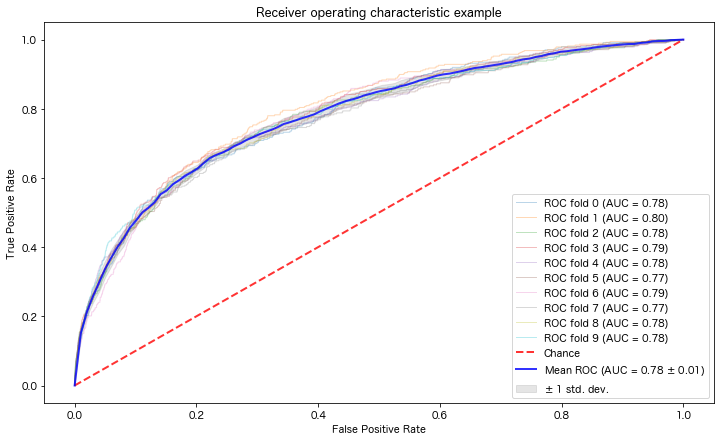

In [78]:
model = classification_and_roc_analysis(k=3, classifier=classifier,
                                                          X_train=X_train.drop(columns=["third_mesh"]),
                                                          y_train=y_train,
                                                          group_id=pd.factorize( X_train.third_mesh.tolist() )[0],visualize=True)[1]

In [85]:
feature_name_table.head()

,name,genuine_name,importance
0,V0,dummy_weekday_type_土,24
1,V1,dummy_weekday_type_日,22
2,V2,dummy_weekday_type_月,16
3,V3,dummy_weekday_type_木,26
4,V4,dummy_weekday_type_水,25


In [84]:
feature_name_table["importance"] = model.feature_importances_.tolist()

In [86]:
feature_name_table.sort_values(by=["importance"], ascending=False).head(20)

,name,genuine_name,importance
83,V83,dummy_day_night_type_夜－夜,80
106,V106,dummy_road_shape_type_単路－カーブ・屈折,62
203,V203,terrain_type_市街地－その他,62
150,V150,dummy_zone_regulation_type_中央分離なし,61
81,V81,dummy_day_night_type_ 昼－昼,54
119,V119,dummy_traffic_lights_type_点灯－３灯式,52
105,V105,dummy_road_shape_type_単路－その他,51
158,V158,dummy_pedestrian_road_division_type_区分あり－防護柵等,50
94,V94,dummy_terrain_type_非市街地,49
205,V205,terrain_type_非市街地,49


In [87]:
y_pred_test = model.predict_proba(X_test.drop(columns=["third_mesh"]))
y_pred_oof = (y_pred_test[:,1] > y_pred_test[:,1].mean()).astype(int)

## 混同行列

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [105]:
labels = ['ok', 'ng']
cm =  confusion_matrix(np.where(y_test.values == 1, 'ok', 'ng') , np.where(  y_pred_oof == 1, 'ok', 'ng'), labels=labels)

# データフレームに変換
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)

# 結果の表示
cm_labeled

,ok,ng
ok,814,307
ng,36960,83661


![エビフライトライアングル](https://camo.qiitausercontent.com/3bcd5c4c035bf0f86d95af0d6c484d1467a5e491/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f37303135322f32396363333765372d666632652d643738312d643461342d6533323866643735323661312e706e67 "サンプル")

<AxesSubplot:>

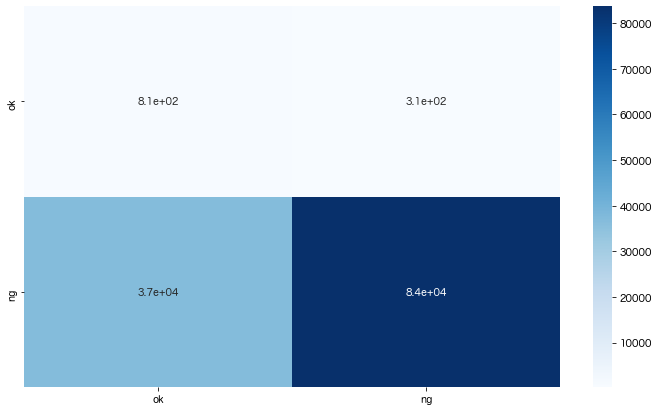

In [108]:
sns.heatmap(cm_labeled, annot=True, cmap='Blues')

![エビフライトライアングル](https://camo.qiitausercontent.com/3bcd5c4c035bf0f86d95af0d6c484d1467a5e491/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f37303135322f32396363333765372d666632652d643738312d643461342d6533323866643735323661312e706e67 "サンプル")

精度・適合率(Precision)

TP / (TP + FP)

In [91]:
cm[0,0]  /(cm[0,0] + cm[1,0])

0.021549213744903904

FN / (FN + TN)

In [94]:
cm[0,1]  /(cm[0,1] + cm[1,1])

0.0036561547256097563

TN / (FN + TN)

In [112]:
cm[1,1]  /(cm[0,1] + cm[1,1])

0.9963438452743902

In [113]:
print(classification_report(np.array(y_test), y_pred_oof))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82    120621
           1       0.02      0.73      0.04      1121

    accuracy                           0.69    121742
   macro avg       0.51      0.71      0.43    121742
weighted avg       0.99      0.69      0.81    121742



# テスト

メッシュ単位、時間帯、天候、時期によっての死亡事故の発生の有無の予測

In [115]:
test_teacher_flag = test_df.death_flag

In [116]:
test_columns = ["weekday_type", "holiday_type", "pref_name", "road_type",
                          "road_bypass", "road_updown_type", "day_night_type",
                          "weather_type", "terrain_type", "road_condition_type",
                          "road_shape_type", "traffic_lights_type", "pause_sign_type_a",
                          "pause_display_type_a", "road_width_type", "road_alignment_type",
                          "zone_regulation_type", "pedestrian_road_division_type",
                          "speed_regulation_type_a", "third_mesh"]

test_df = test_df[test_columns]

In [117]:
# 一気にカテゴリ化
cols = test_columns[:-1]
test_df[cols] = test_df[cols].astype('category')
 
# ダミー変数を一気に作る
for each_columns in cols:
    dummy_df = pd.get_dummies(test_df[each_columns], drop_first= False)
    dummy_df.columns =  ["dummy_" + each_columns + "_" + str(i) for i in dummy_df.columns.tolist()]
    
    test_df = pd.concat([test_df,
                                     dummy_df], axis=1)

In [118]:
test_dataset = pd.concat([test_df["third_mesh"],
                                test_df.filter(regex="dummy_weekday_type"),
                                test_df.filter(regex="dummy_holiday_type"),
                                test_df.filter(regex="dummy_pref_name"),
                                test_df.filter(regex="dummy_road_type"),
                                test_df.filter(regex="dummy_road_bypass"),
                                test_df.filter(regex="dummy_road_updown_type"),
                                test_df.filter(regex="dummy_day_night_type"),
                                test_df.filter(regex="dummy_weather_type"),
                                test_df.filter(regex="dummy_terrain_type"),
                                test_df.filter(regex="dummy_road_condition_type"),
                                test_df.filter(regex="dummy_road_shape_type"),
                                test_df.filter(regex="dummy_traffic_lights_type"),
                                test_df.filter(regex="dummy_pause_sign_type_a"),
                                test_df.filter(regex="dummy_pause_display_type_a"),
                                test_df.filter(regex="dummy_road_width_type"),
                                test_df.filter(regex="dummy_road_alignment_type"),
                                test_df.filter(regex="dummy_zone_regulation_type"),
                                test_df.filter(regex="dummy_pedestrian_road_division_type"),
                                test_df.filter(regex="dummy_speed_regulation_type_a"),
                      ], axis=1)

test_dataset = pd.merge(test_dataset, mesh_summary_df, on="third_mesh", how="left")

In [119]:
test_dataset = test_dataset.fillna(-1)

In [120]:
# 訓練データの列名を残しておく
train_column_list = feature_name_table.genuine_name.tolist()
train_column_list.extend(["third_mesh"])

# 訓練データにはあるが、テストデータにはない変数を0で生成させる
compensate_list = list(set(train_column_list) - set(test_dataset.columns))
if compensate_list != []:
    for each_column in compensate_list:
        test_dataset[each_column] = 0.0

test_dataset = test_dataset[train_column_list]


In [121]:
test_dataset.head()

,dummy_weekday_type_土,dummy_weekday_type_日,dummy_weekday_type_月,dummy_weekday_type_木,dummy_weekday_type_水,dummy_weekday_type_火,dummy_weekday_type_金,dummy_holiday_type_その他,dummy_holiday_type_前日,dummy_holiday_type_当日,dummy_pref_name_三重,dummy_pref_name_京都,dummy_pref_name_佐賀,dummy_pref_name_兵庫,dummy_pref_name_北海道（函館方面）,dummy_pref_name_北海道（北見方面）,dummy_pref_name_北海道（旭川方面）,dummy_pref_name_北海道（札幌方面）,dummy_pref_name_北海道（釧路方面）,dummy_pref_name_千葉,dummy_pref_name_和歌山,dummy_pref_name_埼玉,dummy_pref_name_大分,dummy_pref_name_大阪,dummy_pref_name_奈良,dummy_pref_name_宮城,dummy_pref_name_宮崎,dummy_pref_name_富山,dummy_pref_name_山口,dummy_pref_name_山形,dummy_pref_name_山梨,dummy_pref_name_岐阜,dummy_pref_name_岡山,dummy_pref_name_岩手,dummy_pref_name_島根,dummy_pref_name_広島,dummy_pref_name_徳島,dummy_pref_name_愛媛,dummy_pref_name_愛知,dummy_pref_name_新潟,dummy_pref_name_東京,dummy_pref_name_栃木,dummy_pref_name_沖縄,dummy_pref_name_滋賀,dummy_pref_name_熊本,dummy_pref_name_石川,dummy_pref_name_神奈川,dummy_pref_name_福井,dummy_pref_name_福岡,dummy_pref_name_福島,...,collision_site_type_b_後_右_前_中央,collision_site_type_b_後_右_前_右,collision_site_type_b_後_右_前_左,collision_site_type_b_後_右_右_中央,collision_site_type_b_後_右_左_中央,collision_site_type_b_後_右_後_中央,collision_site_type_b_後_右_後_右,collision_site_type_b_後_右_後_左,collision_site_type_b_後_左_それ以外,collision_site_type_b_後_左_前_中央,collision_site_type_b_後_左_前_右,collision_site_type_b_後_左_前_左,collision_site_type_b_後_左_右_中央,collision_site_type_b_後_左_左_中央,collision_site_type_b_後_左_後_中央,collision_site_type_b_後_左_後_右,collision_site_type_b_後_左_後_左,damage_to_vehicle_type_a_中破,damage_to_vehicle_type_a_大破,damage_to_vehicle_type_a_対象外当事者,damage_to_vehicle_type_a_小破,damage_to_vehicle_type_a_損壊なし,damage_to_vehicle_type_b_中破,damage_to_vehicle_type_b_大破,damage_to_vehicle_type_b_対象外当事者,damage_to_vehicle_type_b_小破,damage_to_vehicle_type_b_損壊なし,airbag_equipment_type_a_その他,airbag_equipment_type_a_対象外当事者,airbag_equipment_type_a_装備あり作動,airbag_equipment_type_b_その他,airbag_equipment_type_b_対象外当事者,airbag_equipment_type_b_装備あり作動,side_airbag_equipment_type_a_その他,side_airbag_equipment_type_a_対象外当事者,side_airbag_equipment_type_a_装備あり作動,side_airbag_equipment_type_b_その他,side_airbag_equipment_type_b_対象外当事者,side_airbag_equipment_type_b_装備あり作動,weekday_type_土,weekday_type_日,weekday_type_月,weekday_type_木,weekday_type_水,weekday_type_火,weekday_type_金,holiday_type_その他,holiday_type_前日,holiday_type_当日,third_mesh
0,0,0,0,0,1,0,0,1,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,64416655
1,0,0,1,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,63417461
2,0,0,1,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,64410552
3,0,0,1,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,64410603
4,0,0,1,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-

In [122]:
test_X = test_dataset.drop(columns=["third_mesh"])

# 変数名をv[0-9]に変更する
test_X.columns = [ 'V' + str(i) for i in range(len(test_X.columns.tolist()))]

test_X = pd.concat([test_X, test_dataset['third_mesh']], axis=1)

In [123]:
y_pred_test = model.predict_proba(test_X.drop(columns=["third_mesh"]))
y_pred_oof = (y_pred_test[:,1] > y_pred_test[:,1].mean()).astype(int)

In [124]:
labels = ['ok', 'ng']
cm =  confusion_matrix(np.where(test_teacher_flag.values == 1, 'ok', 'ng'),np.where(  y_pred_oof == 1, 'ok', 'ng'), labels=labels)

# データフレームに変換
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)

# 結果の表示
cm_labeled

,ok,ng
ok,208,76
ng,7497,16348


In [125]:
result_df = pd.DataFrame(y_pred_test[:,1], columns=["pred_value"])
result_df["death_flag"] = test_teacher_flag
result_df["third_mesh"] = test_X.third_mesh
result_df["prefecture"] = test_df.pref_name

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels=["0~", "1~", "2~","3~","4~","5~", "6~", "7~", "8~", "9~"]

result_df['pred_bins'] = pd.cut(result_df['pred_value'], 
                                             bins=bins,
                                             labels=labels,
                                             include_lowest=True)

In [153]:
# 後でデータの型を指定しておく
def GroupbyPlot(df:pd.DataFrame,
                             group:str,
                             target:str,
                             y_label:str,
                             x_label:str):
    group_name_summary = df.groupby(group)[target].agg([np.mean, "count"])
    index_list = group_name_summary.index.tolist()
    
    group_name_summary = group_name_summary.reset_index()
    
    fig, ax = plt.subplots(figsize=(13,5))
    ax3 = ax.twinx()
    rspine = ax3.spines['right'] 
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)
    group_name_summary["mean"].plot(ax=ax, style='r-', kind="line")
    group_name_summary["count"].plot(ax=ax, secondary_y=True,kind="bar",color='b',alpha=0.5 );
    # ax.set_title('');
    ax.set_ylabel(y_label);
    ax.set_xlabel(x_label); 
    ax.set_xticklabels(index_list, rotation=0);
    ax3.set_ylabel('count');
    ax.legend();
    return group_name_summary

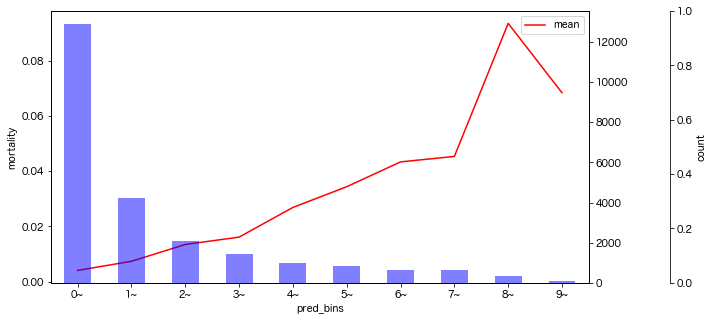

In [154]:
target_string = 'pred_bins'
df_summary = GroupbyPlot(df=result_df, 
                         group=target_string,
                         target="death_flag", y_label="mortality", x_label=target_string)

In [155]:
result_df.sort_values(by="pred_value", ascending=False).head(20)

,pred_value,death_flag,third_mesh,prefecture,pred_bins
17995,0.961011,1,51357062,兵庫,9~
13236,0.955567,0,53370081,岐阜,9~
1785,0.954220,0,55406716,福島,9~
1275,0.951157,0,59404055,秋田,9~
19234,0.949994,0,53340596,兵庫,9~
841,0.948206,0,59413525,岩手,9~
18709,0.947416,0,52352043,兵庫,9~
845,0.945326,0,59417679,岩手,9~
23417,0.944747,0,47305799,宮崎,9~
4675,0.940691,0,54405125,栃木,9~


In [245]:
# vis_df = result_df[(result_df.pred_value > 0.1) & (result_df.death_flag == 1)].reset_index(drop=True)
vis_df = result_df[result_df.pred_value > 0.1].reset_index(drop=True)

In [246]:
vis_df

,pred_value,death_flag,third_mesh,prefecture,pred_bins
0,0.727767,0,64416655,北海道（札幌方面）,7~
1,0.180929,1,63417461,北海道（札幌方面）,1~
2,0.576730,0,64410552,北海道（札幌方面）,5~
3,0.503093,0,64410603,北海道（札幌方面）,5~
4,0.445148,0,63417460,北海道（札幌方面）,4~
...,...,...,...,...,...
11227,0.200681,0,39272523,沖縄,2~
11228,0.160684,0,39272522,沖縄,1~
11229,0.363434,0,39272542,沖縄,3~
11230,0.338423,0,39272543,沖縄,3~


# folium

In [247]:
def get_latlon(meshCode):

    # 文字列に変換
    meshCode = str(meshCode)

    # １次メッシュ用計算
    code_first_two = meshCode[0:2]
    code_last_two = meshCode[2:4]
    code_first_two = int(code_first_two)
    code_last_two = int(code_last_two)
    lat  = code_first_two * 2 / 3
    lon = code_last_two + 100

    if len(meshCode) > 4:
        # ２次メッシュ用計算
        if len(meshCode) >= 6:
            code_fifth = meshCode[4:5]
            code_sixth = meshCode[5:6]
            code_fifth = int(code_fifth)
            code_sixth = int(code_sixth)
            lat += code_fifth * 2 / 3 / 8
            lon += code_sixth / 8

        # ３次メッシュ用計算
        if len(meshCode) == 8:
            code_seventh = meshCode[6:7]
            code_eighth = meshCode[7:8]
            code_seventh = int(code_seventh)
            code_eighth = int(code_eighth)
            lat += code_seventh * 2 / 3 / 8 / 10
            lon += code_eighth / 8 / 10

    return lat, lon

In [248]:
get_latlon(64416655)

(43.20833333333333, 141.8125)

In [249]:
list(vis_df.third_mesh.map(get_latlon))

[(43.20833333333333, 141.8125),
 (42.63333333333333, 141.5125),
 (42.70833333333333, 141.65),
 (42.666666666666664, 141.7875),
 (42.63333333333333, 141.5),
 (43.099999999999994, 141.3625),
 (43.05, 141.3375),
 (43.06666666666667, 141.325),
 (43.041666666666664, 141.4125),
 (43.05, 141.425),
 (43.05, 141.4),
 (43.05, 141.425),
 (43.041666666666664, 141.4125),
 (43.041666666666664, 141.4125),
 (43.06666666666667, 141.425),
 (43.09166666666666, 141.3),
 (43.08333333333333, 141.2875),
 (43.05833333333333, 141.2875),
 (43.08333333333333, 141.2875),
 (43.06666666666667, 141.2875),
 (43.099999999999994, 141.4125),
 (43.09166666666666, 141.35),
 (43.06666666666667, 141.375),
 (43.099999999999994, 141.3625),
 (43.08333333333333, 141.4),
 (43.08333333333333, 141.3875),
 (43.099999999999994, 141.4375),
 (43.099999999999994, 141.4125),
 (43.12499999999999, 141.4),
 (43.09166666666666, 141.4375),
 (43.06666666666667, 141.35),
 (43.06666666666667, 141.55),
 (43.08333333333333, 141.5),
 (43.05, 141.5

In [250]:
vis_df[["latitude", "longitude"]] = list(vis_df.third_mesh.map(get_latlon))

In [251]:
vis_df[["latitude", "longitude"]]

,latitude,longitude
0,43.208333,141.8125
1,42.633333,141.5125
2,42.708333,141.6500
3,42.666667,141.7875
4,42.633333,141.5000
...,...,...
11227,26.183333,127.6625
11228,26.183333,127.6500
11229,26.200000,127.6500
11230,26.200000,127.6625


In [252]:
vis_df.prefecture.value_counts()

神奈川          1005
愛知            789
千葉            756
静岡            680
東京            643
埼玉            606
兵庫            513
福岡            415
大阪            401
群馬            393
長野            315
茨城            270
栃木            247
宮崎            237
佐賀            199
宮城            196
広島            189
滋賀            177
岡山            175
鹿児島           163
福島            160
北海道（札幌方面）     156
香川            155
山形            148
青森            143
新潟            143
奈良            136
長崎            133
岐阜            131
富山            130
大分            117
沖縄            110
京都            107
愛媛            107
三重            105
石川            104
山口             99
徳島             96
岩手             84
山梨             81
秋田             75
熊本             68
和歌山            54
高知             42
北海道（釧路方面）      36
福井             35
島根             34
鳥取             29
北海道（函館方面）      17
北海道（旭川方面）      16
北海道（北見方面）      12
Name: prefecture, dtype: int64

In [253]:
#各都市にデータを振り分け
vis_df_hokkaido = vis_df.loc[vis_df.prefecture == '北海道（札幌方面）']
vis_df_tokyo = vis_df.loc[vis_df.prefecture == '東京']
vis_df_kanagawa = vis_df.loc[vis_df.prefecture == '神奈川']
vis_df_aichi = vis_df.loc[vis_df.prefecture == '愛知']

In [254]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

In [255]:
#ここでは、東京に絞って分析します。
# folium_df = vis_df_tokyo

#全国で
folium_df = vis_df

In [256]:
folium_df_lat_mean=folium_df.latitude.mean()
folium_df_lng_mean=folium_df.longitude.mean()
folium_df_y_max = folium_df.pred_value.max() #今回のデータは上限側に大きく振れるものがあるので使っていません。
folium_df_min = folium_df.pred_value.min()

In [259]:
m = folium.Map(location=[folium_df_lat_mean,  folium_df_lng_mean], zoom_start = 11) 

colormap = cm.LinearColormap(['green', 'yellow', 'red'],vmin=folium_df_min, vmax=folium_df_y_max)
#colormap = cm.StepColormap(colors=['green','yellow','orange','red'] ,index=[min_price,105,190,327,max_price],vmin= min_price,vmax=max_price)
#cm.LinearColormap.to_step

for loc, p in zip(zip(folium_df["latitude"],folium_df["longitude"]),folium_df["pred_value"]):
    folium.Circle(
        location=loc,
        radius=2,
        fill=True,
        color=colormap(p),
        #popup=
        #fill_opacity=0.7
    ).add_to(m)

In [261]:
# m